# VISNLP Dataset

In [1]:
from torch.utils.data import Dataset,DataLoader
import joblib
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import os
from torch import tensor
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from warnings import filterwarnings
filterwarnings('ignore')

class VisualNLPCustomDataset(Dataset):
    def __init__(self,dataframe,image_path):
        self.data = joblib.load(dataframe)
        self.image_path = image_path
        self.mapping = {'선천성유문협착증':'Pyloric Stenosis','공기액체음영':'air-fluid level',
                        '기복증':'Abdominal distension','변비':'Constipation','정상':'Normal'}
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = os.path.join(self.image_path, row['ImagePath'], row['Filename'])
        image = Image.open(image_path).convert('RGB')
        transform = transforms.ToTensor()
        image_tensor = transform(image)
        meta = self.mapping[row['ImagePath'].split('.')[-1]]
        return image_tensor, meta, row['Caption']
    
train = VisualNLPCustomDataset('../Dataset/Train_Data.pkl','../Data/Training/01.원천데이터')
test = VisualNLPCustomDataset('../Dataset/Validation_Data.pkl','../Data/Validation/01.원천데이터')
image_tensor, meta, text = train[0] # 3,512,512 (정규화된 Tensor Image: 소아 복부 X_ray : RGB), Caption: 'This plain abdominal radiograph reveals marked..'
text

'This plain abdominal radiograph of an about 1-month-old male infant shows markedly distended stomach.'

# VISUAL+NLP DataLoader

In [2]:
train_dataloader = DataLoader(train,5,True)
test_dataloader = DataLoader(train,5,False)
batch_image_tensor,batch_meta,batch_text = next(iter(train_dataloader))
print(batch_image_tensor.shape) # (batchsize:3, 3, 512, 512)
print(batch_text) # (batchsize:3, 3개의 Texts)
print(batch_meta)

torch.Size([5, 3, 512, 512])
('This plain abdominal radiograph reveals right-sided shows moderate free air with no ileus and absence of fecal retention.', 'A plain abdominal radiograph with both sides massive free air with paralytic ileus and no fecal retention.', 'This plain abdominal radiograph shows paralytic air-fluid level.', 'This plain abdominal radiograph reveals a normal bowel gas pattern.', 'This plain erect abdominal radiograph shows both sides show moderate free air with no ileus and no fecal retention.')
('Abdominal distension', 'Abdominal distension', 'air-fluid level', 'Normal', 'Abdominal distension')


# Cross Attention - VIS + NLP Integrated Vector 확인하기

In [3]:
from VISNLP import ViTFeatureExtractor, BertFeatureExtractor, CrossAttention, VISNLPEXTRACTOR, CaptionGenerator, CaptionDecoder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_WIDTH = 512
IMG_DIM_HEIGHT = 512
PATCH_SIZE = 16
EMBED_DIM = 256
NUM_HEADS = 4
DEPTH = 4
FF_DIM = 2048
NUM_LAYERS = 4

model = VISNLPEXTRACTOR(
    img_dim_h=IMG_DIM_HEIGHT,
    img_dim_w=IMG_WIDTH,
    patch_size=PATCH_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    depth=DEPTH
).to('cpu')

batch_image_tensor = batch_image_tensor.to('cpu')
integrated_feature = model(batch_image_tensor,batch_meta)
integrated_feature # [Batch Size, 256]

tensor([[ 0.0667,  0.0659,  0.0406,  ...,  0.0402,  0.0945,  0.1320],
        [ 0.0667,  0.0659,  0.0406,  ...,  0.0402,  0.0945,  0.1320],
        [-0.0583,  0.0220,  0.0239,  ...,  0.0939,  0.1014,  0.0715],
        [ 0.0071,  0.0341, -0.0125,  ...,  0.0207,  0.1648,  0.1080],
        [ 0.0667,  0.0659,  0.0406,  ...,  0.0402,  0.0945,  0.1320]],
       grad_fn=<SqueezeBackward1>)

# 학습 전, (VIS + Meta) Cross Attention Integrated Vector - t-SNE 시각화 / Cosine Similarity

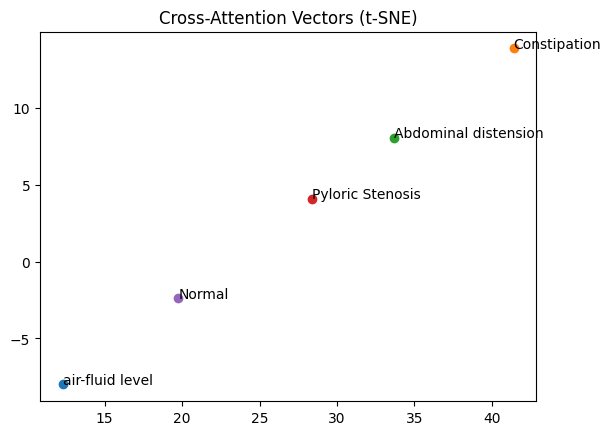

In [66]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vecs_np = integrated_feature.cpu().detach().numpy()
tsne = TSNE(n_components=2, perplexity=1, random_state=42)
emb_2d = tsne.fit_transform(vecs_np)

for i in range(len(emb_2d)):
    plt.scatter(emb_2d[i][0], emb_2d[i][1])
    plt.text(emb_2d[i][0]+0.01, emb_2d[i][1]+0.01, batch_meta[i])
plt.title("Cross-Attention Vectors (t-SNE)")
plt.show()

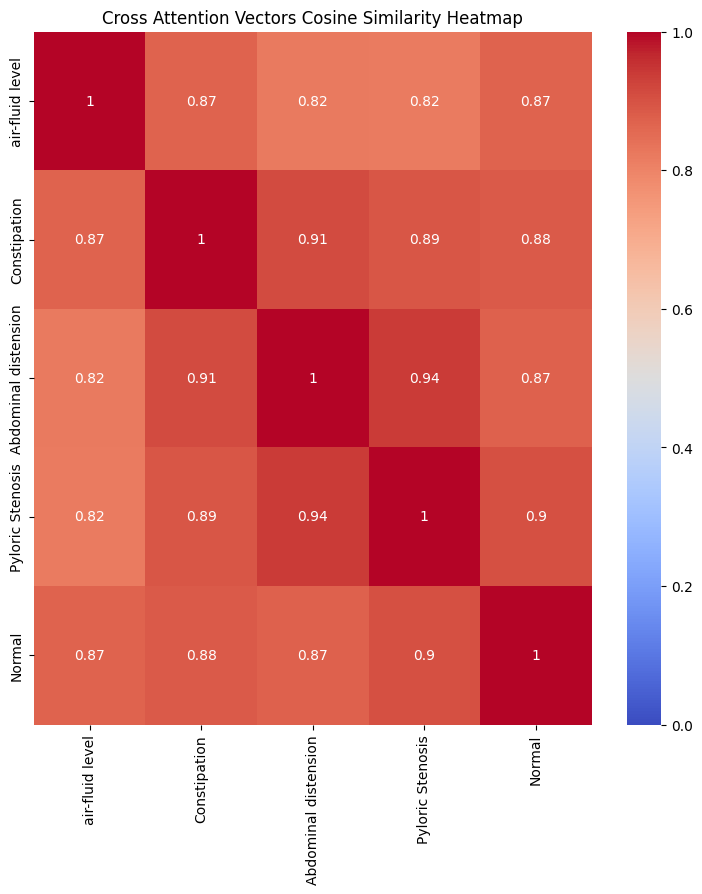

In [62]:
import seaborn as sns
cosine_sim = F.cosine_similarity(integrated_feature.unsqueeze(1), integrated_feature.unsqueeze(0), dim=-1)
cosine_sim_np = cosine_sim.cpu().detach().numpy()

# 라벨 (진단명)
labels = batch_meta

# 히트맵 그리기
plt.figure(figsize=(9,9))
sns.heatmap(cosine_sim_np, xticklabels=labels, yticklabels=labels, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cross Attention Vectors Cosine Similarity Heatmap")
plt.show()

# 

# Caption Decoder

In [67]:
from transformers import AutoTokenizer
from torch import nn
from tqdm import tqdm
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = CaptionGenerator(
    VISNLPEXTRACTOR(IMG_DIM_HEIGHT, IMG_WIDTH, PATCH_SIZE, EMBED_DIM, NUM_HEADS, DEPTH),
    vocab_size=30522,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS
).to(device)

In [ ]:
from transformers import AutoTokenizer
from torch import nn
from tqdm import tqdm
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

for epoch in range(1):
    print(f"\n--- Epoch {epoch + 1} ---")

    # ========== Training ==========
    model.train()
    total_loss, total_correct, total_tokens = 0.0, 0, 0

    for step, (images, metas, captions) in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        images = images.to(device)
        metas = list(metas)

        tokenized = tokenizer(
            list(captions),
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=48
        ).to(device)

        captions_input = tokenized['input_ids'][:, :-1]
        captions_target = tokenized['input_ids'][:, 1:]

        logits = model(images, metas, captions_input)
        loss = loss_fn(logits.view(-1, logits.size(-1)), captions_target.reshape(-1))

        preds = logits.argmax(dim=-1)
        mask = captions_target != tokenizer.pad_token_id
        correct = ((preds == captions_target) & mask).sum().item()
        total = mask.sum().item()
        acc = correct / total if total > 0 else 0

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += correct
        total_tokens += total

        if (step + 1) % 400 == 0:
            print(f"[Train Step {step + 1}] Loss: {loss.item():.4f}, Accuracy: {acc * 100:.2f}%")

    avg_loss = total_loss / len(train_dataloader)
    avg_acc = total_correct / total_tokens if total_tokens > 0 else 0
    print(f"[TRAIN][Epoch {epoch + 1}] Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_acc * 100:.2f}%")

    # ========== Evaluation ==========
    model.eval()
    total_loss, total_correct, total_tokens = 0.0, 0, 0

    with torch.no_grad():
        for step, (images, metas, captions) in enumerate(tqdm(test_dataloader, desc="Evaluating", leave=False)):
            images = images.to(device)
            metas = list(metas)

            tokenized = tokenizer(
                list(captions),
                return_tensors='pt',
                padding='max_length',
                truncation=True,
                max_length=48
            ).to(device)

            captions_input = tokenized['input_ids'][:, :-1]
            captions_target = tokenized['input_ids'][:, 1:]

            logits = model(images, metas, captions_input)
            loss = loss_fn(logits.view(-1, logits.size(-1)), captions_target.reshape(-1))

            preds = logits.argmax(dim=-1)
            mask = captions_target != tokenizer.pad_token_id
            correct = ((preds == captions_target) & mask).sum().item()
            total = mask.sum().item()

            total_loss += loss.item()
            total_correct += correct
            total_tokens += total

    avg_loss = total_loss / len(test_dataloader)
    avg_acc = total_correct / total_tokens if total_tokens > 0 else 0
    print(f"[TEST][Epoch {epoch + 1}] Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_acc * 100:.2f}%")


# 학습 후 VIS + NLP Integrated Vectors 

In [72]:
# Load
print(model.load_state_dict(torch.load('Model_Parameters.pth',map_location='cpu')))

<All keys matched successfully>


In [153]:
test = VisualNLPCustomDataset('../Dataset/Validation_Data.pkl','../Data/Validation/01.원천데이터')
test_dataloader = DataLoader(test,5, True)

batch_test_images, batch_test_metas, batch_test_texts = next(iter(test_dataloader))
print(batch_test_images.shape, batch_test_images.__len__())
print(batch_test_metas)

torch.Size([5, 3, 512, 512]) 5
('Normal', 'Pyloric Stenosis', 'Abdominal distension', 'Constipation', 'air-fluid level')


In [154]:
with torch.no_grad():
    integrated_test_feature = model.extractor(batch_image_tensor, batch_test_metas)

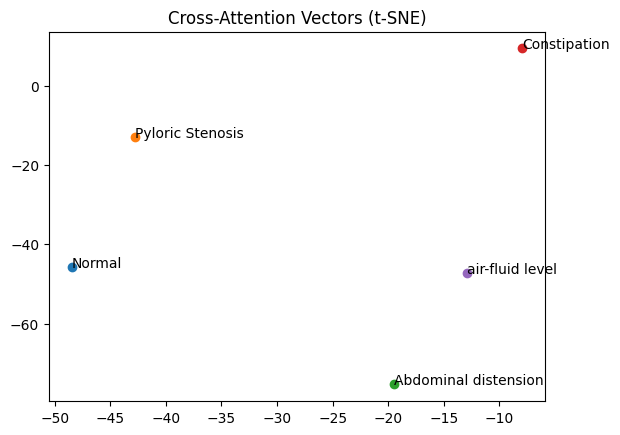

In [156]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

vecs_np = integrated_test_feature.cpu().detach().numpy()
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
emb_2d = tsne.fit_transform(vecs_np)

for i in range(len(emb_2d)):
    plt.scatter(emb_2d[i][0], emb_2d[i][1])
    plt.text(emb_2d[i][0]+0.01, emb_2d[i][1]+0.01, batch_test_metas[i])
plt.title("Cross-Attention Vectors (t-SNE)")
plt.show()

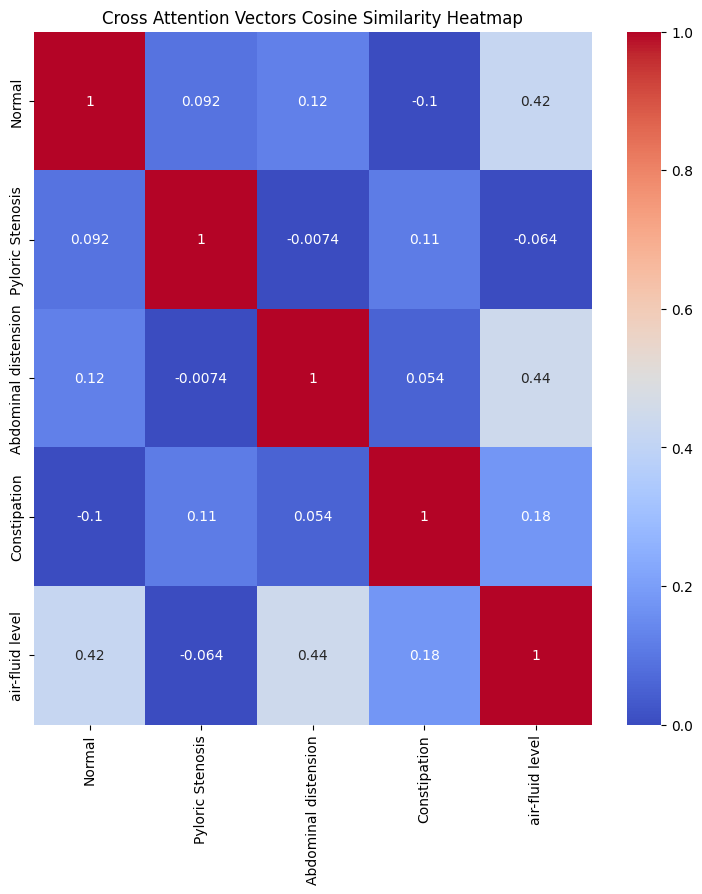

In [157]:
import seaborn as sns
cosine_sim = F.cosine_similarity(integrated_test_feature.unsqueeze(1), integrated_test_feature.unsqueeze(0), dim=-1)
cosine_sim_np = cosine_sim.cpu().detach().numpy()

# 라벨 (진단명)
labels = batch_test_metas

# 히트맵 그리기
plt.figure(figsize=(9,9))
sns.heatmap(cosine_sim_np, xticklabels=labels, yticklabels=labels, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cross Attention Vectors Cosine Similarity Heatmap")
plt.show()

# Test Predict (Generate Text)

Generated Caption: this plain plain abdominal radiograph shows both sides show subtle free air with mechanical ileus and presence of fecal retention.


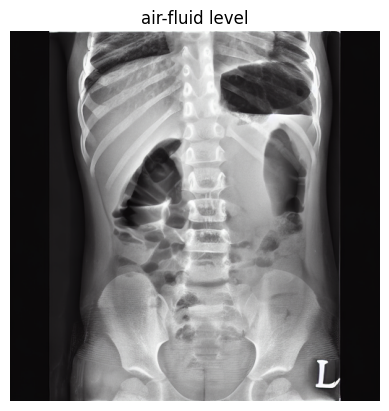

In [158]:
import torchvision.transforms as T
def generate_caption(model, image, meta, tokenizer, max_len=48, device='cpu'):
    model.eval()
    image = image.unsqueeze(0).to(device)         # [1, 3, H, W]
    meta = [meta]                                 # List[str]

    with torch.no_grad():
        memory = model.extractor(image, meta).to(device)     # [1, D]
        
        # 시작 토큰 ([CLS] 또는 [BOS])
        input_ids = torch.tensor([[tokenizer.cls_token_id]], device=device)  # [1, 1]

        for _ in range(max_len - 1):
            logits = model.decoder(input_ids, memory)  # [1, T, vocab_size]
            next_token_logits = logits[:, -1, :]       # [1, vocab_size]
            next_token = torch.argmax(next_token_logits, dim=-1)  # [1]

            input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim=1)

            if next_token.item() == tokenizer.sep_token_id:  # [SEP] 나오면 중단
                break

    # 토큰을 문장으로 디코딩
    caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    return caption

def show_image(tensor_img, title=None):
    # Clone to avoid modifying original tensor
    img = tensor_img.cpu().clone()
    img = torch.clamp(img, 0, 1)

    # Convert to HWC for matplotlib
    img = img.permute(1, 2, 0).numpy()
    
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# 예시 이미지, 메타
sample_img, sample_meta, _ = next(iter(test_dataloader))  # 배치 중 일부 사용
sample_img = sample_img[0]          # [3, H, W]
sample_meta = sample_meta[0]        # str

# Generate caption
caption = generate_caption(model, sample_img, sample_meta, tokenizer, device=device)
print("Generated Caption:", caption)

show_image(sample_img, title=sample_meta)

- '선천성유문협착증':'Pyloric Stenosis',
- '공기액체음영':'air-fluid level',
- '기복증':'Abdominal distension', (배의 공기가 들어있는 상태 -> 궤양, 복부가 천공이 되었을 때 발생하는 증상)
- '변비':'Constipation',
- '정상':'Normal'

# 모델 저장

In [ ]:
# torch.save(model, 'Model_Structure.pth')
# torch.save(model.state_dict(), 'Model_Parameters.pth')

# Computer Resource가 더 좋아지면, 학습을 더 사용

In [ ]:
# from transformers import AutoTokenizer, AutoModel
# from torch import nn

# tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# model = CaptionGenerator(VISNLPEXTRACTOR(IMG_DIM_HEIGHT,IMG_WIDTH,PATCH_SIZE,EMBED_DIM,NUM_HEADS,DEPTH),30522,EMBED_DIM,NUM_HEADS,FF_DIM,NUM_LAYERS).to(device)

# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id).to(device)
# NUM_EPOCHS = 10

# for epoch in range(NUM_EPOCHS):
#     model.train()
#     total_loss = 0.0
#     total_tokens = 0
#     total_correct = 0

#     for images, metas, captions in train_dataloader:
#         images = images.to(device)
#         metas = list(metas)

#         tokenized = tokenizer(
#             list(captions),
#             return_tensors='pt',
#             padding='max_length',
#             truncation=True,
#             max_length=48
#         )
#         input_ids = tokenized['input_ids'].to(device)

#         captions_input = input_ids[:, :-1]  # [B, T-1]
#         captions_target = input_ids[:, 1:]  # [B, T-1]

#         logits = model(images, metas, captions_input)  # [B, T-1, vocab_size]

#         loss = loss_fn(logits.view(-1, logits.size(-1)), captions_target.reshape(-1))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # === Accuracy 계산 ===
#         pred_ids = logits.argmax(-1)  # [B, T-1]
#         mask = (captions_target != tokenizer.pad_token_id)  # [B, T-1]

#         correct = (pred_ids == captions_target) & mask
#         total_correct += correct.sum().item()
#         total_tokens += mask.sum().item()

#         # === Loss 누적 ===
#         total_loss += loss.item()

#     avg_loss = total_loss / len(train_dataloader)
#     accuracy = total_correct / total_tokens if total_tokens > 0 else 0

#     print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy*100:.2f}%")
